In [1]:
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import pipeline
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import nltk


In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords

complete_stopwords = set(stopwords.words("portuguese"))

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = '../data/articles.csv'
df = pd.read_csv(data)

In [5]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

filtered_df = df[(df['date'].dt.year == 2015) & (df['date'].dt.month <= 3) & (df['category'].str.lower() == 'mercado')]

In [6]:
checkpoint = 'monilouise/ner_pt_br'
tokenizer = BertTokenizerFast.from_pretrained(checkpoint)
model = BertForTokenClassification.from_pretrained(checkpoint)     

Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
ner_pipeline = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

/usr/local/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [8]:
def extract_organizations(text):
    entities = ner_pipeline(text)
    organizations = []
    current_org = ""

    for entity in entities:
        if entity['entity_group'] == 'ORG':
            word = entity['word']
            if word.startswith("##"):
                current_org += word[2:]
            else:
                if current_org:
                    organizations.append(current_org)
                current_org = word
        else:
            if current_org:
                organizations.append(current_org)  
                current_org = ""  
    if current_org:
        organizations.append(current_org) 

    return organizations

In [9]:
all_organizations = []
for article in tqdm(filtered_df['text'], desc="Processando artigos"):
    extracted_orgs = extract_organizations(article)
    all_organizations.extend(extracted_orgs)

organization_counts = Counter(all_organizations)

Processando artigos:   0%|          | 0/2111 [00:00<?, ?it/s]

In [10]:
ranking = organization_counts.most_common()
ranking_df = pd.DataFrame(ranking, columns=['Organization', 'Count'])

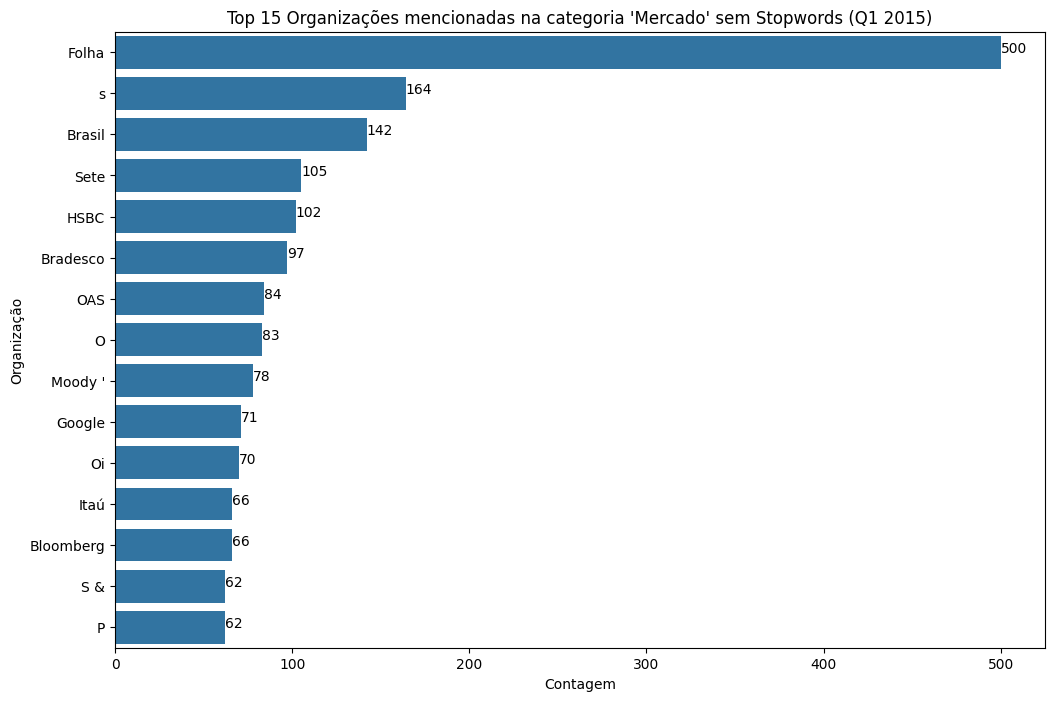

In [54]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Organization', data=ranking_df.head(15))
plt.title("Top 15 Organizações mencionadas na categoria 'Mercado' sem Stopwords (Q1 2015)")
plt.xlabel("Contagem")
plt.ylabel("Organização")
for index, value in enumerate(ranking_df.head(15)['Count']):
    plt.text(value, index, str(value))

plt.show()

In [45]:
organization_string = " ".join(all_organizations)

In [55]:
def filter_stopwords(text):
    words = text.split()
    filtered_terms = {"'",'"',"&", "s", "-", "f", "c", "b", "p"}
    filtered_words = [word for word in words if word.lower() not in complete_stopwords and word.lower() not in filtered_terms]
    return " ".join(filtered_words)


filtered_organization_string = filter_stopwords(organization_string)

In [56]:
filtered_all_organizations = filter_stopwords(organization_string).split()
filtered_organization_counts = Counter(filtered_all_organizations)
filtered_ranking = filtered_organization_counts.most_common()
filtered_ranking_df = pd.DataFrame(filtered_ranking, columns=['Organization', 'Count'])

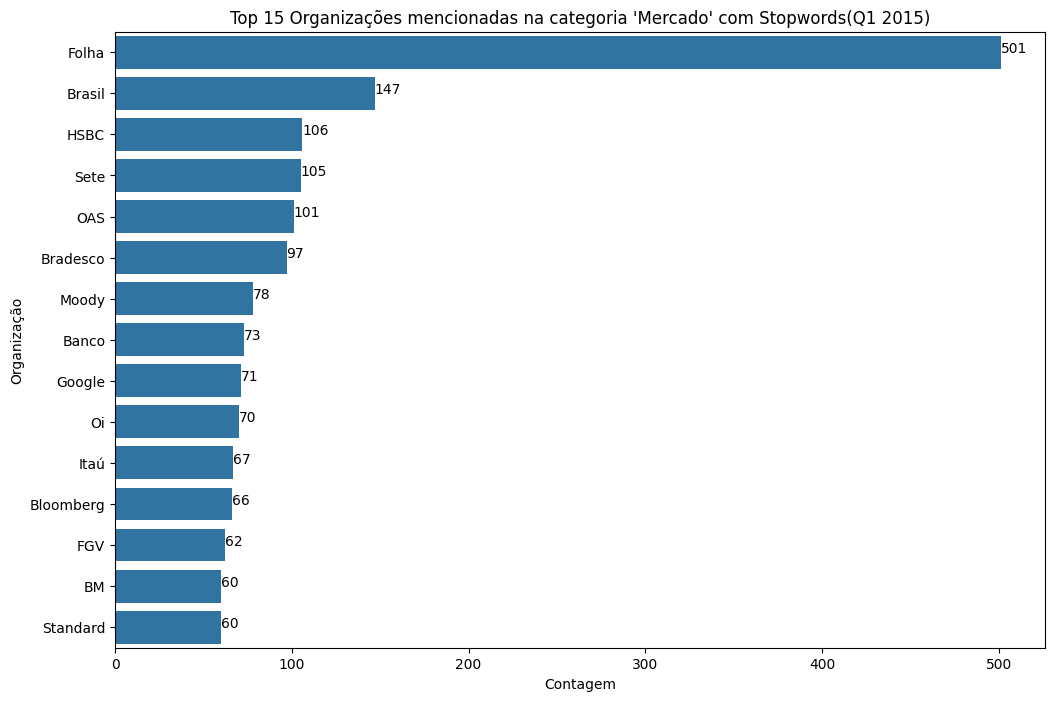

In [57]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Organization', data=filtered_ranking_df.head(15))
plt.title("Top 15 Organizações mencionadas na categoria 'Mercado' com Stopwords(Q1 2015)")
plt.xlabel("Contagem")
plt.ylabel("Organização")
for index, value in enumerate(filtered_ranking_df.head(15)['Count']):
    plt.text(value, index, str(value))

plt.show()

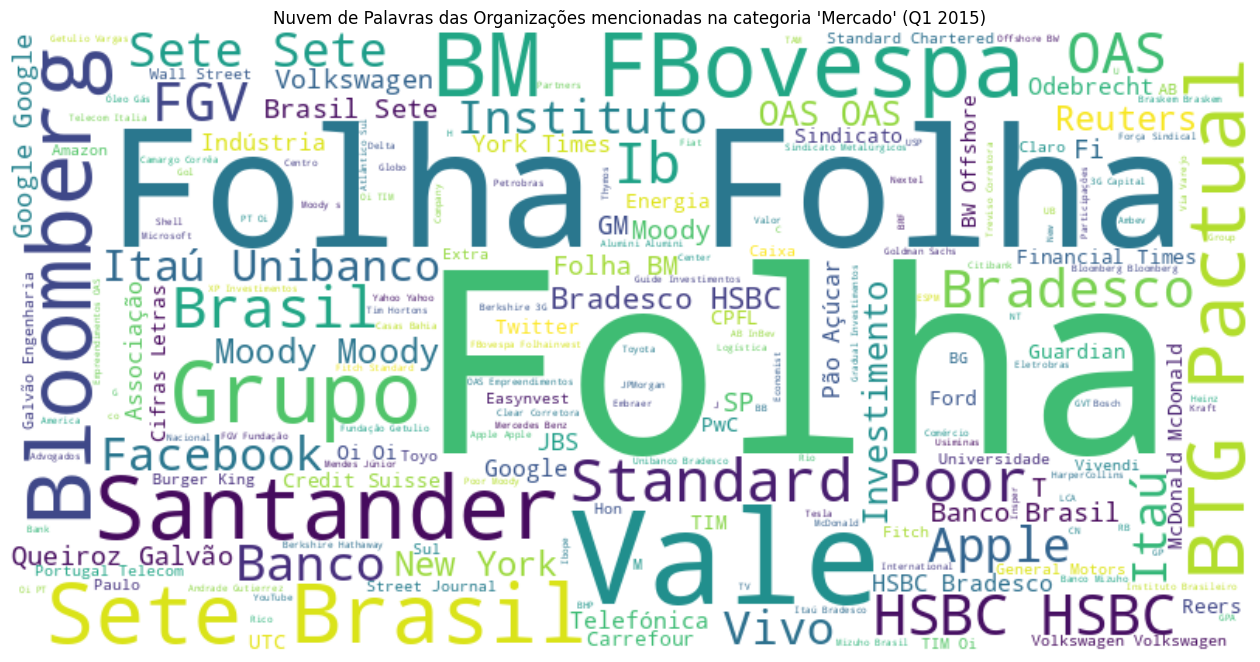

In [58]:
def plot_wordcloud(text, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

fig, ax = plt.subplots(figsize=(16, 12))
plot_wordcloud(filtered_organization_string, ax)
ax.set_title("Nuvem de Palavras das Organizações mencionadas na categoria 'Mercado' (Q1 2015)")
plt.show()